In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
sns.set(color_codes=True)

Shape: (2591, 14)
   Team1 Name  Team1 Runs Scored  Team1 Wickets Fell  Team2 Name  \
0          40           0.230769                 1.0           2   
1          26           0.612179                 0.8          65   
2          80           0.336538                 0.8          64   
3          49           0.333333                 0.9          80   
4         102           0.333333                 0.8          89   

   Team2 Runs Scored  Team2 Wickets Fell  Match Venue (Stadium)  \
0           0.278431                 0.1                    118   
1           0.545098                 0.8                     83   
2           0.415686                 0.5                     32   
3           0.403922                 0.1                     32   
4           0.403922                 0.5                    113   

   Match Venue (City)  Match Venue (Country)  Toss Winner  Match Winner  \
0                 111                      1           41             2   
1                  4

C:\Users\upekk\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\upekk\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\upekk\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i


🎲 Toss Choice Prediction Accuracy: 0.5841392649903289
              precision    recall  f1-score   support

       False       0.57      0.53      0.55       248
        True       0.59      0.63      0.61       269

    accuracy                           0.58       517
   macro avg       0.58      0.58      0.58       517
weighted avg       0.58      0.58      0.58       517



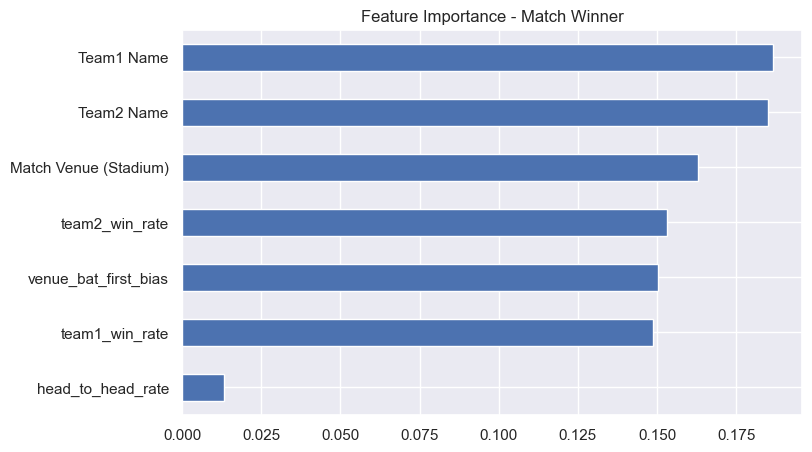

In [11]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder # Still needed for other categorical columns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# -----------------------------
# 1. Load Dataset
# -----------------------------
# Assuming your new file already contains the OHE columns
df = pd.read_csv("t20i_Matches_Data_Final.csv")

print("Shape:", df.shape)
print(df.head())

# -----------------------------
# 2. Basic Preprocessing (CORRECTED & SIMPLIFIED)
# -----------------------------
# We no longer need to Label Encode the Toss Choice.
# We only Label Encode the required categorical team/venue columns.

# Categorical columns to encode (excluding the now OHE toss columns)
cat_cols = ["Team1 Name", "Team2 Name", "Match Venue (Stadium)", 
            "Toss Winner", "Match Winner", 
            "Match Venue (City)", "Match Venue (Country)"] # Added city/country for safety

encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le

# Create the 'Toss_Decision' target column directly from the OHE columns
# 0 = bat (Toss Winner Choice_bat == 1)
# 1 = bowl (Toss Winner Choice_bowl == 1)
df["Toss_Decision"] = df["Toss Winner Choice_bowl"].copy() # This works because 1 (bowl) or 0 (bat) is captured here.

# Filter out rows where the match was called off/no decision
df = df[df["Toss Winner Choice_match called off"] == 0].copy()

# Drop the individual OHE columns as we now have Toss_Decision
df.drop(columns=['Toss Winner Choice_bat', 
                 'Toss Winner Choice_bowl', 
                 'Toss Winner Choice_match called off'], inplace=True) 

# -----------------------------
# 3. Feature Engineering
# -----------------------------

# a) Team overall win rate
team_win_rate = df["Match Winner"].value_counts() / len(df)
df["team1_win_rate"] = df["Team1 Name"].map(team_win_rate).fillna(0.5)
df["team2_win_rate"] = df["Team2 Name"].map(team_win_rate).fillna(0.5)

# b) Head-to-head win rate
def head_to_head(row):
    t1, t2 = row["Team1 Name"], row["Team2 Name"]
    mask = ((df["Team1 Name"] == t1) & (df["Team2 Name"] == t2)) | \
           ((df["Team1 Name"] == t2) & (df["Team2 Name"] == t1))
    matches = df[mask]
    if len(matches) == 0:
        return 0.5
    # Calculate the proportion of matches won by Team1 (t1) in the head-to-head
    return (matches["Match Winner"] == t1).mean()

df["head_to_head_rate"] = df.apply(head_to_head, axis=1)

# c) Venue batting bias (how often "bat first" was chosen at that venue)
venue_bat_bias = df.groupby("Match Venue (Stadium)")["Toss_Decision"].apply(lambda x: (x == 0).mean())
df["venue_bat_first_bias"] = df["Match Venue (Stadium)"].map(venue_bat_bias)

# -----------------------------
# 4. Match Winner Prediction
# -----------------------------
# Note: Team1/Team2 Name is used as a feature because it is Label Encoded (numerical)
X_winner = df[["Team1 Name", "Team2 Name", "Match Venue (Stadium)",
               "team1_win_rate", "team2_win_rate", "head_to_head_rate", "venue_bat_first_bias"]]
y_winner = df["Match Winner"]

X_train, X_test, y_train, y_test = train_test_split(X_winner, y_winner, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("\n🎯 Match Winner Prediction Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# -----------------------------
# 5. Toss Choice Prediction
# -----------------------------
X_toss = df[["Match Venue (Stadium)", "team1_win_rate", "team2_win_rate", "head_to_head_rate", "venue_bat_first_bias"]]
y_toss = df["Toss_Decision"]  # 0 = bat, 1 = bowl

X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_toss, y_toss, test_size=0.2, random_state=42)

clf_toss = RandomForestClassifier(n_estimators=200, random_state=42)
clf_toss.fit(X_train_t, y_train_t)

y_pred_t = clf_toss.predict(X_test_t)

print("\n🎲 Toss Choice Prediction Accuracy:", accuracy_score(y_test_t, y_pred_t))
print(classification_report(y_test_t, y_pred_t))

# -----------------------------
# 6. Feature Importance Plot
# -----------------------------
feat_importances = pd.Series(clf.feature_importances_, index=X_winner.columns)
feat_importances.sort_values().plot(kind="barh", figsize=(8,5))
plt.title("Feature Importance - Match Winner")
plt.show()